In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import warnings
import joblib

# Import Data

In [4]:
# Read the data from the specified sheet into a pandas DataFrame
data = pd.read_csv('/content/Data_Churn.csv')

# Display the first few rows of the fetched data
print(data.head())

  Customer_ID  Gender  Age  Married           State  Number_of_Referrals  \
0   11098-MAD  Female   30     True  Madhya Pradesh                    0   
1   11114-PUN    Male   51    False          Punjab                    5   
2   11167-WES  Female   43     True     West Bengal                    3   
3   11179-MAH    Male   35    False     Maharashtra                   10   
4   11180-TAM    Male   75     True      Tamil Nadu                   12   

   Tenure_in_Months Value_Deal Phone_Service Multiple_Lines  ...  \
0                31     Deal 1           Yes             No  ...   
1                 9     Deal 5           Yes             No  ...   
2                28     Deal 1           Yes            Yes  ...   
3                12        NaN           Yes             No  ...   
4                27     Deal 2           Yes             No  ...   

    Payment_Method Monthly_Charge Total_Charges Total_Refunds  \
0  Bank Withdrawal            951         66834             0   
1  B

# Data Preprocessing

In [5]:
# Drop columns that won't be used for prediction
data_cleaned = data.drop(['Customer_ID', 'Churn_Category', 'Churn_Reason'], axis=1)

In [6]:
# Encode all categorical variables using LabelEncoder
label_encoders = {}
for column in data_cleaned.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data_cleaned[column] = le.fit_transform(data_cleaned[column])
    label_encoders[column] = le

In [7]:
# Define features (X) and target (y)
# In the encoded 'Customer_Status', 'Churned' is 0 and 'Stayed' is 2.
status_encoder = label_encoders['Customer_Status']
print(f"Label Encoder Mapping for Customer_Status: {dict(zip(status_encoder.classes_, status_encoder.transform(status_encoder.classes_)))}")

Label Encoder Mapping for Customer_Status: {'Churned': np.int64(0), 'Stayed': np.int64(1)}


In [8]:
# Filter the data to only include 'Churned' and 'Stayed' customers
# Assume 'Churned' is 0 and 'Stayed' is 2 from the mapping
churn_value = status_encoder.transform(['Churned'])[0]
stayed_value = status_encoder.transform(['Stayed'])[0]

final_data = data_cleaned[data_cleaned['Customer_Status'].isin([churn_value, stayed_value])]

X = final_data.drop('Customer_Status', axis=1)
y = final_data['Customer_Status']

In [9]:
# Split the data into training and testing sets, ensuring balanced classes in the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Data Balancing

In [10]:
# Handle Class Imbalance with SMOTE
print("--- Handling Class Imbalance with SMOTE ---")
print("Class distribution before SMOTE:")
print(y_train.value_counts())

--- Handling Class Imbalance with SMOTE ---
Class distribution before SMOTE:
Customer_Status
1    3420
0    1385
Name: count, dtype: int64


In [11]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nClass distribution after SMOTE:")
print(y_train_smote.value_counts())
print("SMOTE applied successfully.\n")


Class distribution after SMOTE:
Customer_Status
1    3420
0    3420
Name: count, dtype: int64
SMOTE applied successfully.



# Train Model with Balancing And Hyperparamater Tuning

In [12]:
#Hyperparameter Tuning with GridSearchCV
print("--- Tuning Hyperparameters with GridSearchCV ---")
# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy']
}

# Instantiate the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Instantiate GridSearchCV to find the best parameters for 'recall'
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring='recall', verbose=2)

# Fit GridSearchCV to the balanced training data
print("Starting Grid Search...")
grid_search.fit(X_train_smote, y_train_smote)

# Get the best model
best_rf_model = grid_search.best_estimator_

print("\nBest Parameters Found:")
print(grid_search.best_params_)
print("Hyperparameter tuning complete.\n")

--- Tuning Hyperparameters with GridSearchCV ---
Starting Grid Search...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best Parameters Found:
{'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 200}
Hyperparameter tuning complete.



# Evaluate Model with Balancing And Hyperparamater Tuning


In [13]:
# Evaluate the Optimized Model
print("--- Evaluating the Optimized Model ---")
# Make predictions on the unseen test set
y_pred = best_rf_model.predict(X_test)

# Display the evaluation metrics
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Churned', 'Stayed']))
print("Evaluation complete.\n")

--- Evaluating the Optimized Model ---

Confusion Matrix:
[[235 112]
 [109 746]]

Classification Report:
              precision    recall  f1-score   support

     Churned       0.68      0.68      0.68       347
      Stayed       0.87      0.87      0.87       855

    accuracy                           0.82      1202
   macro avg       0.78      0.77      0.78      1202
weighted avg       0.82      0.82      0.82      1202

Evaluation complete.



--- Analyzing Feature Importance ---


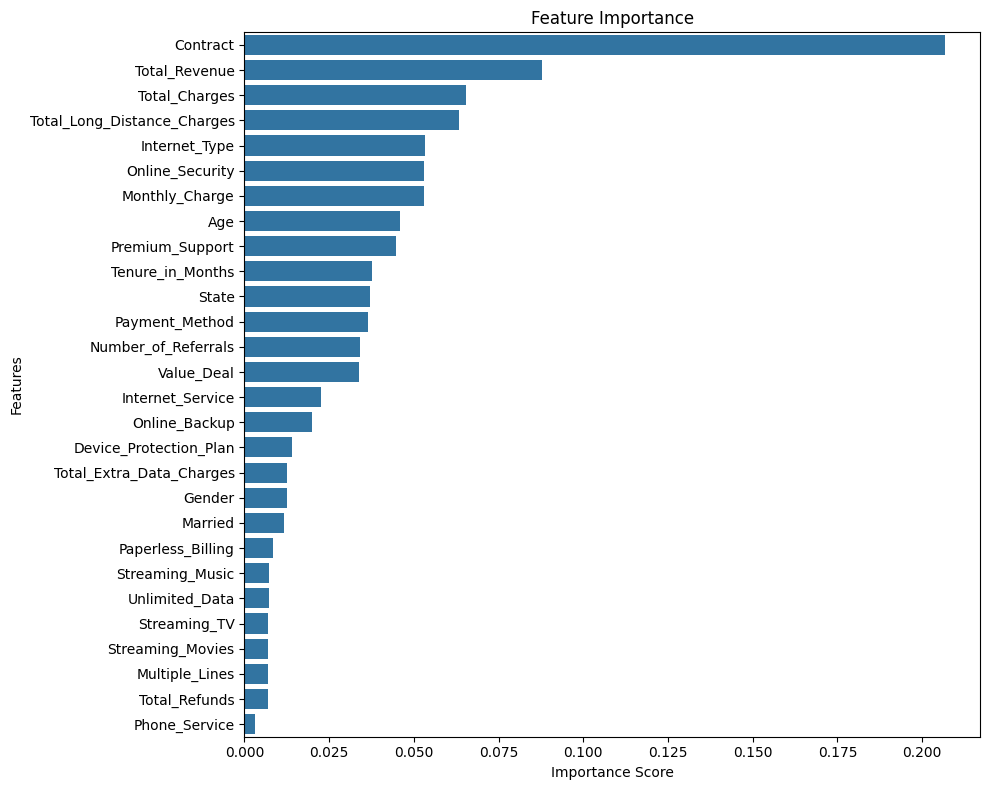

Feature importance analysis complete.


In [14]:
# Feature Importance
print("--- Analyzing Feature Importance ---")
feature_importances = pd.DataFrame(best_rf_model.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances.importance, y=feature_importances.index)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()
print("Feature importance analysis complete.")

# Use Model for Prediction on New Data

In [15]:
# Read the data from the specified sheet into a pandas DataFrame
new_data = pd.read_csv('/content/Prediction_Data_Join.csv')

# Display the first few rows of the fetched data
print(new_data.head())

  Customer_ID  Gender  Age  Married        State  Number_of_Referrals  \
0   11751-TAM  Female   18    False   Tamil Nadu                    5   
1   12056-WES    Male   27    False  West Bengal                    2   
2   12136-RAJ  Female   25     True    Rajasthan                    2   
3   12257-ASS  Female   39    False        Assam                    9   
4   12340-DEL  Female   51     True        Delhi                    0   

   Tenure_in_Months Value_Deal Phone_Service Multiple_Lines  ...  \
0                 7     Deal 5            No             No  ...   
1                20        NaN           Yes             No  ...   
2                35        NaN           Yes             No  ...   
3                 1        NaN           Yes             No  ...   
4                10        NaN           Yes             No  ...   

    Payment_Method Monthly_Charge Total_Charges Total_Refunds  \
0     Mailed Check            243          3845             0   
1  Bank Withdrawal    

In [16]:
# Keep a copy of the original data
final_report_df = new_data.copy()

In [17]:
# Prepare the Data for Prediction
print("Preparing data for prediction...")
# Drop columns that are not used as features by the model.
new_data_features = new_data.drop(['Customer_ID', 'Customer_Status', 'Churn_Category', 'Churn_Reason'], axis=1)

Preparing data for prediction...


In [18]:
# Robust Encoding for Categorical Variables
print("Encoding categorical variables...")
for column in new_data_features.select_dtypes(include=['object']).columns:
    if column in label_encoders:
        le = label_encoders[column]
        known_classes = list(le.classes_)

        # Apply transformation, replacing unseen values with -1 (unknown category)
        new_data_features[column] = new_data_features[column].apply(
            lambda x: le.transform([x])[0] if x in known_classes else -1
        )
    else:
        print(f"Warning: Encoder for column '{column}' not found. Skipping.")
print("Encoding complete.")

Encoding categorical variables...
Encoding complete.


In [19]:
# Make Predictions with the Best Model
print("Making predictions with the tuned model...")
# Use the 'best_rf_model' that was trained with SMOTE and GridSearchCV
new_predictions_numeric = best_rf_model.predict(new_data_features)

Making predictions with the tuned model...


In [20]:
# Decode Predictions into Human-Readable Labels
print("Decoding predictions into text labels...")
# Get the encoder for the target variable 'Customer_Status'
status_encoder = label_encoders['Customer_Status']
# Use inverse_transform to convert numbers back to original labels ('Churned', 'Stayed')
new_predictions_text = status_encoder.inverse_transform(new_predictions_numeric)

Decoding predictions into text labels...


In [21]:
# Create and Save the Final Report
print("Creating and saving the final prediction reports...")
# Add the new prediction column to the full original DataFrame
final_report_df['Predicted_Status'] = new_predictions_text

# Filter and save a report for churned customers only ---
# Create a new DataFrame containing only the customers predicted to churn
churned_only_df = final_report_df[final_report_df['Predicted_Status'] == 'Churned'].copy()

# Save the churn-only report to a new CSV file
churned_only_df.to_csv('Churned_Only_Prediction.csv', index=False)
print("Report for churn-risk customers saved to 'Churned_Only_Prediction.csv'")


print("\nPrediction complete!")
print("\nFirst 5 rows of the full report:")
# Display the head of the full report
print(final_report_df.head())

Creating and saving the final prediction reports...
Report for churn-risk customers saved to 'Churned_Only_Prediction.csv'

Prediction complete!

First 5 rows of the full report:
  Customer_ID  Gender  Age  Married        State  Number_of_Referrals  \
0   11751-TAM  Female   18    False   Tamil Nadu                    5   
1   12056-WES    Male   27    False  West Bengal                    2   
2   12136-RAJ  Female   25     True    Rajasthan                    2   
3   12257-ASS  Female   39    False        Assam                    9   
4   12340-DEL  Female   51     True        Delhi                    0   

   Tenure_in_Months Value_Deal Phone_Service Multiple_Lines  ...  \
0                 7     Deal 5            No             No  ...   
1                20        NaN           Yes             No  ...   
2                35        NaN           Yes             No  ...   
3                 1        NaN           Yes             No  ...   
4                10        NaN           Y